# "Pump it Up: Data Mining the Water Table"

Data Wrangling & Pre-Processing

Jason & Tom

In [1]:
## Install On First Usage
# pip install shapely 

In [2]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import string

from sklearn.preprocessing import LabelEncoder

# Data Wrangling & Pre-Processing

This notebook explains the steps we tooks to wrangle, clean & pre-process our data in preparation for EDA & Modelling.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [3]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

# 1.0 Data Cleaning

## 1.1 Imputation

### 1.1.1 Lat/Lon Imputation

First, we wanted to impute the lat/lon data as some of it was (0, 0). 

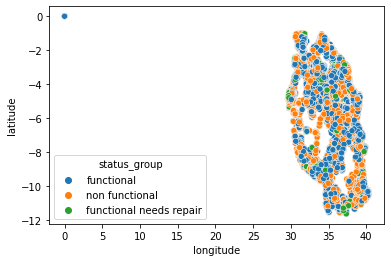

In [4]:
# Author [Tom]

## Original Data
sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.show()

In [5]:
# Author [Jason]

df['longitude_imputation'] = df['longitude']
df['latitude_imputation'] = df['latitude']

df['longitude_imputation'] = df['longitude_imputation'].replace(0, np.nan)
df['longitude_imputation'] = df['longitude_imputation'].fillna(df.groupby('region')['longitude_imputation'].transform('mean'))

df['latitude_imputation'] = df['latitude_imputation'].replace(-2.000000e-08, np.nan)
df['latitude_imputation'] = df['latitude_imputation'].fillna(df.groupby('region')['latitude_imputation'].transform('mean'))

<AxesSubplot:xlabel='longitude_imputation', ylabel='latitude_imputation'>

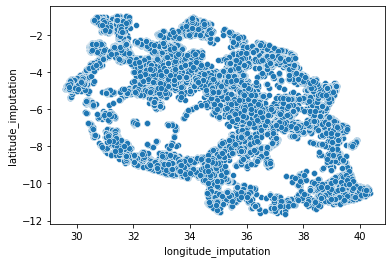

In [6]:
# Author [Jason]

sns.scatterplot(data=df, x='longitude_imputation', y='latitude_imputation')

In [7]:
# Author [Tom]

df['longitude'].replace(0, np.nan, inplace=True)
df['longitude'] = df['longitude'].fillna(df.groupby(['region', 'lga','ward'])['longitude'].transform('mean'))
df['longitude'] = df['longitude'].fillna(df.groupby(['region', 'lga'])['longitude'].transform('mean'))
df['longitude'] = df['longitude'].fillna(df.groupby('region')['longitude'].transform('mean'))
df.loc[df['latitude'] == -2.000000e-08, 'latitude'] = np.nan
df['latitude'] = df['latitude'].fillna(df.groupby(['region', 'lga', 'ward'])['latitude'].transform('mean'))
df['latitude'] = df['latitude'].fillna(df.groupby(['region', 'lga'])['latitude'].transform('mean'))
df['latitude'] = df['latitude'].fillna(df.groupby('region')['latitude'].transform('mean'))

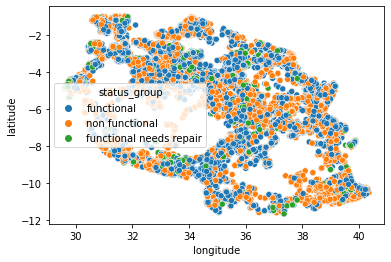

In [8]:
# Author [Tom]

## New Data
sns.scatterplot(df, x='longitude', y='latitude', hue='status_group')
plt.show()

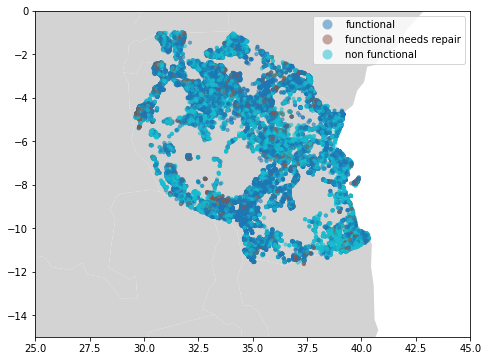

In [9]:
# Author [Tom]

## The data overlayed on an actual map of Tanzania.

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(10, 6), facecolor="lightgrey"), column='status_group', alpha=0.5, legend=True, markersize=10);
ax.set_xlim(25, 45)
ax.set_ylim(-15, 0)
plt.show()

df.drop('geometry', axis=1, inplace=True)


### 1.1.2 Population

There are a lot of 0 values in population, we can impute them like so. We also want to replace all the values in population by the mean value of the subvillage. There are instances of the same subvillage having different populations.

In [10]:
df['population_original'] = df['population']

In [11]:
# Author [Tom]

df['population'] = df['population'].replace(0, np.nan)

df['population'] = df['population'].fillna(df.groupby(['region', 'lga', 'ward'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby(['region', 'lga', 'ward'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby(['region', 'lga'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('region')['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('basin')['population'].transform('mean'))

In [12]:
# Author [Tom]

df['population_mean'] = df.groupby(['basin', 'region', 'ward', 'lga', 'subvillage'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region', 'ward', 'lga'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region', 'ward'])['population'].transform('mean')
df['population_mean'] = df.groupby(['basin', 'region'])['population'].transform('mean')

### 1.1.3 Permit

The n/a values will be replaced with "Unknown"

In [13]:
# Author [Jason]

df['permit'] = df['permit'].fillna("Unknown")

In [14]:
df['permit'].value_counts()

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

Text(0.5, 1.0, 'Permit')

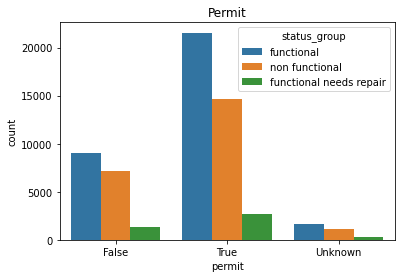

In [15]:
sns.countplot(data=df, x='permit', hue='status_group', dodge=1.0)
plt.title('Permit')

### 1.1.4 Public Meeting

The NaNs will be replaced with "Unknown"

In [16]:
# Author [Jason]

df['public_meeting'] = df['public_meeting'].fillna("Unknown")

In [17]:
df['public_meeting'].value_counts()

True       51011
False       5055
Unknown     3334
Name: public_meeting, dtype: int64

Text(0.5, 1.0, 'Public Meeting')

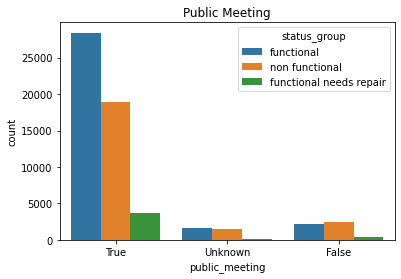

In [18]:
sns.countplot(data=df, x='public_meeting', hue='status_group', dodge=1.0)
plt.title('Public Meeting')

## 1.2 Column Binning

### 1.2.1 Funder & Installer

The funder and installer columns are quite similar in terms of values, we wanted to bin them into categories of:

    - Foreign Aid
    - National Government
    - Local Goverment
    - Religious
    - Private
    - Charity
    - School
    - Unknown
    
Unfortunately, we could not find a method to do this automatically, we tried NER (https://spacy.io/api/entityrecognizer). However, due to the rare nature of the data this didn't work. We had to do this by hand.

Here are the lists of values that comprise each class. We also made some assumptions on certain values

    - Any acronyms that are similar to a known acronym are classed as that acronym
            - 'Rwssp' is the known acronym; 'Rwsssp', 'Rssp', 'Wrssp' are all classed as 'Rwssp'
    - Some funder are just the water supply from which the water comes. These are classed as private companies
    - Schools & Universities are classed as local governments as they are often public schools, so the money comes from the council
    - DWE stands for District Water Engineer, however this is grouped with multiple parties such as NORAD (gov) or RCC (regilous). When DWE is on it's own it is local_gov, however what it is grouped with takes priority.
    - RWE (or regionwal WE) are government entities.

In [19]:
foreign = ['Danida', 'Germany Republi','Netherlands', 'Norad','Jica', 'Jaica',
          'Nethalan', 'Swedish', 'Germany','China Government' 'Dwe/norad', 'Tz Japan',
          'European Union', 'Dads', 'Holland', 'Swiss If', 'Jika', 'Nethe', 'Dadis',
          'Norad/ Kidep', 'The People of Japan', 'Finland Government', 
          'A/co Germany', 'Us Embassy', 'Finland', 'Jeica', 'Aco/germany',  'Canada',
          'Belgian Government', 'People Of Japan', 'World Bank', 'British Colonial Government',
          'France', 'Gaica', 'U.S.A', 'Greec', 'Sweden', 'Japn Embassy',
          'Colonial Government', 'Japan Aid', 'Italy Government', 'Usa Embassy', 'China Government',
           'Watu Wa Ujerumani',  'Norad /government', 'Un', 'The People Of Japan', 'Eu/acra',
           'Ubalozi Wa Marekani', 'Franc', 'Comune Di Roma', 'Japan Food',  'Netherland', 'Korea', 'Japan Embassy',
           'Danida /government', 'World Bank/government', 'Unhcr/government', 'Norad/government', 'Japan Government', 'Irish Government',
           'Egypt Government',  'Iran Gover', 'Italy', 'British Tanza',  'People From Japan','Norad/ Tassaf Ii',
           'Niger', 'Morad', 'Sweeden', 'Dqnida', 'Holand', 'Norad/ Tassaf', 'Foreigne', 
           'Watu Wa Marekani', 'Italian', 'Natherland', 'Ubalozi Wa Japani', 'Japan  Food Aid Counter Part', 
           'Embasy Of Japan In Tanzania', 'People From Egypt', 'Daida', 'Nerthlands', 'Norad/rudep', 'Norad/japan', 'Netherla', 'People Of Sweden',
           'Canada Aid', 'Unhcr/danida', 'Danid', 'DANID', 'DA', 'Egypt Technical Co Operation', 'Eu',
           'Irish Ai', 'Friend From Un', 'Japan', 'Grobal resource alliance', 'Japan Food Aid', 'Ddca',
           'WOULD BANK', 'Belgiam Government', 'NORAD/', 'China', 'JAICA CO', 'AUSTRALIA', 'Belgij',
           'ITALI', 'DENISH', 'IRAN GOVERN', 'NIRAD', 'Word Bank', 'Britain', 'British government',
           'WORLD NK', 'Chinese', 'Wizra ya maji na egypt', 'Hilfe Fur Bruder', 'DANIDS', 'DANNIDA',
           'Italian government', 'GERMAN', 'Word bank', 'Tanz/Egypt technical coopera',
           'WORDL BANK',
          ]

In [20]:
gov = ['Government Of Tanzania', 'Rwssp', 'Ministry Of Water',  'Lga', 'Dwsp',
        'Rural Water Supply And Sanitat', 'Wsdp','Tanza', 'Kuwait', 'Finida German Tanzania Govt', 
       'Dwssp', 'Cipro/government', 'Water Board',  'Tanzania', 'Isf/government', 'Rwsp',
       'Government/ Community', 'Finidagermantanzania Govt', 'Government/ World Bank',  'Member of Parliament',
       'Government /tassaf',  'Rwsssp',  'Tassaf/ Danida', 'Rwssp/wsdp', 'Ministry of Education',
        'Rssp','Koica and Tanzania Government','Ministry of Water', 'Dhv', 'Water', 'Rudep', 'W.B',
       'Tassaf', 'Undp', 'Gtz', 'Padep', 'National Rural','Idara Ya Maji',  'Dwe/norad', 'Serikali', 
       "Dhv\\norp",'Ifad','Tanzakesho', 'Dhv Moro', 'Rural Water Supply And Sanita', 'National Rural And Hfa',
       'Dhv/gove', 'Bffs', 'Tassaf Ii', 'Parastatal','Ministry Of Education', 'Wrssp', 'Tcrs /government',
       'Domestic Rural Development Pro', 'Rural Drinking Water Supply', 'Kaemp' ,'Tasaf And Lga',
       'Tasaf Ii' ,'Tasae', 'Taasaf', 'Isf / Tasaff','Tasaf And Lga', 'Tasaf And Mmem',
       'Tasaf 1', 'Tasaf/tlc', 'Tasa', 'Rural Water Department','Water Sector Development',
       'Water Department', 'Domestic Water Supply Project','District Rural Project', 'Vgovernment', 
       'Government /sda', 'Misri Government','Government And Community', 'Government/tassaf',
       'Government/tcrs','Government /world Vision', 'Government', 'Handeni Trunk Main(',
       'Domestic Rural Development Pr',  'Ministry Of Agricultura','Ministry Of Healthy', 'Rwssp Shinyanga',
       'Government Of Misri', 'Tassaf I',  'Overnment',  'Rudep/norad','Rudep /dwe', 
       'Tasf', 'Ded/rwssp', 'Dwe/rudep', 'Health  Ministry', 'Go', 'Dh',
       'Ridep', 'Tredep', 'Kirdep', 'Tridep', 'Kidep', 'Redep', 'Padep(mifugo)',
       'Dasip', 'Pidp', 'Asb', 'Ukiligu', 'Rdc', 'Imf', 'Sao H',  'Benguka', 'Dasp', 'Healt', 'Mem', 'Cbhi',
       'Nsc', 'Ddp', 'Hesawz', 'Dbspe', 'Tanapa', 'Tanap', 'Pmo', 'Simmors', 'Wizara', 'Doddea', 'Tirdo',
        'Rural Water Supply', 'Dassip', 'Sswp', 'Tanroad', 'Tpp', 'Wajerumani', 'Tasef', 'Tanzania /egypt',
       'Treedap', 'Prodap', 'National Park',  'Afya Department Lindi Rural',
       'Chama Cha Ushirika', 'Wdsp', 'Tanload', 'Hesswa', 'Hesawza','Hewawa', 'Hewasa', 'Isf/gvt', 'Hesawwa',
       'Drwssp', 'Tanzania Egypt Technical Co Op', 'Dagida', 'Hesawa', 'He', 'RWE', 'Central government',
        'Gover', 'Gove', 'Distri', 'Centr', 'MWE', 'Central govt', 'GOVER', 'Central Government',
         'Region water Department',  'RWE/DWE', 'MWE &', 'Wizara ya maji', 'Tanzania Government', 'KIDP',
       'GOVERN', 'TAWASA',  'TAN PLANT LTD', 'GEOTAN', 'NORA','central government', 'Tanz', 'UKILIG',
       'RWE /Community', 'CENTRAL GOVERNMENT', 'RW', 'Canada na Tanzania', 'RUDEP/', 'Ministry of water engineer',
       'RWE/ Community', 'RUDE', 'RWE/Community', 'ADRA /Government', 'Cental Government', 'TASAF/', 'WE',
       'Cebtral Government', 'UN ONE', 'KOICA', 'Tanzanian Government', 'TASSAF /TCRS', 'Plan Tanzania',
       'GOVERM', 'World banks','GOVERNME', 'RWE Community', 'Selikali', 'World Division', 'REDAP',
       'CIPRO', 'Governme', 'TANCRO', 'TAIPO', 'RWE/TCRS', 'Noshad', 'Handeni Trunk Main',
       'Mpango wa Mwisa', 'Centra Government', 'HEESAW', 'Governmen', 'HESAW', 'TASAF and Comunity',
       'DWE /TASSAF', 'HESAWS', 'Cetral government /RC', 'Centra govt',
      ] 


In [21]:
local_gov = ['District Council', 'Mkinga Distric Coun', 'Mkinga Distric Cou', 'Kibaha Town Council',
            'Village Government', 'Songea District Council', 'Songea Municipal Counci',
            'Wua', 'Villagers', 'Village Council', 'Community', 'Muwsa', 'Halmashauri Ya Wilaya Sikonge',
             'Hsw', 'Vwc', 'Ncaa', 'Mkinga  Distric Cou', 'Losaa-kia Water Supply', 'Commu',
             'Kilindi District Co', 'Tabora Municipal Council',  'Kuwasa', 'Mbiuwasa',
             'Water User As', 'Tuwasa', 'Halmashauri', 'Village', 'Kilwater', 'Village Community',
             'Sekei Village Community', 'Singida Yetu', 'Sowasa', 'Makonde Water Population', 
             'Sumbawanga Munici', 'Bahewasa', 'Olgilai Village Community', 'Village Council/ Haydom Luther',
             'Halmashauri Ya Manispa Tabora', 'Lgcdg', 'Lowasa', 'Kinapa', 'Auwasa', 'Suwasa', 'Mzinga A',
             'Serikali Ya Kijiji', 'Regional Water Engineer Arusha', 'Water User Group', 'Ikela Wa', 'Council',
             'Sengerema District Council', 'Mtuwasa', 'Mamlaka Ya Maji Ngara', 'Halmashaur', 'Mbozi District Council',
             'Village Govt', 'Sauwasa', 'Kyela Council', 'Duwas' ,'Sangea District Council', 'Municipal Council',
             'Mheza Distric Counc', 'Ilkeri Village', 'Kigoma Municipal', 'Mwanga Town Water Authority',
             'Local', 'Villa', 'Mtuwasa And Community', 'Ngiresi Village Community', 'Liuwassa', 'Nduku Village',
             'Oldadai Village Community', 'Halmashauri Ya Wilaya', 'Mdrdp', 'Ndrdp', 'Government/school',
             'Muwasa', 'Dawasa', 'Suasa', 'Village Water Commission', 'Kigoma Municipal Council',
             'Villege Council', 'Village Council/ Rose Kawala', 'Wb / District Council', 'Cdtfdistrict Council',
             'Village Fund', 'Halmashauli', 'Solar Villa', 'Gesawa', 'Villaers', 'Comunity Construction Fund',
             'Village Contributio', 'Dar Es Salaam Round Table', 'Marumbo Community', 'Village Communi',
             'Gra Na Halmashauri', 'Kitiangare Village Community', 'Halmashauri Wil', 'Village Office',
             'Subvillage', 'Tcrs/village Community', 'Village Res', 'Villagers Mpi', 'Villegers', 'Villages',
             'Villlage Contributi', 'Ilwilo Community', 'Kwa Ditriki Cho', 'Tlc/community', 'Halimashauli',
             'Okutu Village Community', 'Buluga Subvillage Community', 'Nyamingu Subvillage', 'Igolola Community',
             'Town Council', 'Community Bank', "Oak'zion' And Bugango B' Commu", 'School', 'Longido Sec School',
              'Mdc', 'Isingiro Ho', 'Rundu Man', 'Runduman', 'Lvemp', 'Lgdcg', 'Lgcbg', 'Ifakara', 'Lcdg', 
             'Ardhi Instute', 'Education Funds', 'Mfuko Wa Jimbo La Magu',
             'Kondo Primary', 'Maseka Community', 'Cdft',  'Lgcgd', 'Manyovu Agriculture Institute',
             'Selikali Ya Kijiji', 'Wanakijiji', 'Kwa Mzee Waziri', 'Kijij', 
             'Sengerema Water Department', 'Magadini-Makiwaru wa', 'Dwe',
             'District water department', 'Adra/Community', 'Adra /Community', 'Communit',
             'District water depar', 'DWE}', 'District Counci', 'VILLAG', 'Vill', 'Ardhi water well',
             'DWE/', 'Sangea District Coun', 'COUN', 'VILLAGE COUNCIL Orpha', 'Songea District Coun',
             'SHUWASA', 'DADS/village community', 'Counc', 'District  Council', 'Serengeti District concil',
             'DEE', 'Village Counil', 'Halmashauri/Quick win project', 'Villager', 'Maendeleo ya jamii',
             'NDDP', 'Municipal', 'Comunity', 'VILLAGER', 'Village water committee', 'MDRD_',
             'ESAWA', 'Water users Group', 'District Community j', 'Water boards', 'Village community members',
             'Lindi rural water department', 'Engarasero villagers', 'Distric Water Department',
             'VILLAGE COUNCIL .ODA', 'Taboma/Community', 'Villi', 'villigers', 'MBULU DISTRICT COUNCIL',
             'DWE/Ubalozi wa Marekani', 'Ubalozi wa Marekani /DWE', 'DWE/TASSAF', 'DWE&',
            ] 

In [22]:
school = ['Secondary Schoo', 'Kwang-nam Middle-school', 'Schoo', 'Loliondo Secondary', 'Mbozi Secondary School',
         'Prince Medium School', 'Kibaha Independent School', 'Eastmeru Medium School', 'Overland High School',
             'Luchelegu Primary School', 'School Adm9nstrarion', 'Tingatinga Sec School', 'Poland Sec School',
             'Manyota Primary School', 'S.P.C Pre-primary School', 'Upendo Primary School',
         'Mwl. Nyerere Sec. School', 'Shule Ya Sekondari Ipuli', 'Shule Ya Msingi', 'Shule Ya Msingi Ufala',
          'Kagunguli Secondary', 'Scholastica Pankrasi', 'Sekondari', 'Orphanage', 'Zingibali Secondary',
          'secondary school',
         ]

In [23]:
private = ['Private Individual', 'Adb', 'Private', 'Ces(gmbh)', 'Shipo', 'Ces (gmbh)',
          'African Development Bank', 'Bank', 'Private Owned', 'Williamsom Diamon Ltd', 'I.E.C',
          'Priva', 'Tulawaka Gold Mine', 'Nyamongo Gold Mining', 'Geita Goldmain',
          'Kiliwater', 'Wananchi', 'Dfid', 'Donor', 'Jbg', 'Aar', 'Biore', 'Songas', 'Bgm', 'Sabodo',
           'Mwaya Mn', 'Swisland/ Mount Meru Flowers', 'Tado', 'Resolute Mining',
           'Fpct', 'Bulyahunlu Gold Mine', 'Snv Ltd', 'Williamson Diamond Ltd', 'Hortanzia',
           'Professor Ben Ohio University', 'Member Of Parliament', 'San Pellegrino', 'Simon Lusambi',
           'Robert Loyal', 'Dawasco', 'Regwa Company Of Egypt',  'Jgb', 'Lawatefuka Water Supply', 'Sabemo',
           'Lawate Fuka Water Supp', 'Fresh Water Plc England', 'Resolute Golden Pride Project',
           'Regina Group', 'Ngelepo Group', 'Ikeuchi Towels Japan', 'Fiwater', 'Swisland/mount Meru Flowers',
           'Ten Degree Hotel', 'African Barrick Gold', 'Bio Fuel Company', 'Vicfish Ltd', 'Kibo Brewaries',
           'Stephano Paulo', 'Steven Nyangarika', 'Geochaina', 'Losakia Water Supply', 'Safari Roya',
           'Mzungu Paul', 'Lawate Fuka Water Suppl', 'Hotels And Loggs Tz Ltd', 'Private Person',
           'Regwa Company Of Egpty', 'Judge Mchome', 'Mmg Gold Mine', 'Company', 'Egypt', 'Peter Tesha',
           'Peter Ngereka','Peters', 'Peter', 'Institution', "Lee Kang Pyung's Family", 'Wafidhi Wa Ziwa T',
           'John Gileth', 'Private Individul', 'Member Of Perliament Ahmed Ali', 'Richard M.Kyore',
           'Bonite Bottles Ltd', 'Robert Mosi', 'Private Co', 'Otelo Bussiness Company',
           'Peter Mayiro', 'Private Institutions', 'John Skwese', 'Old Nyika Company', 'Paulo Sange',
           'Prof. Saluati', 'Robert Kampala', 'Dasp Ltd', 'Hotels And Lodge Tanzania', 'Kayempu Ltd', 
           'Maswi Drilling Co. Ltd', 'Q-sem Ltd', 'Luke Samaras Ltd', 'Q-sem Ltd', 'Hans', 'Rished',
           'Mkuyu', 'Shule', 'Konoike', 'Magadini Makiwaru Water', 'Tanesco', 'Kijiji', 'Mwelia Estate',
           'Vickfis', 'Mtibwa S', 'Vodacom', 'Greinaker', 'Makonde Water Supply', 'Zao Water Spring',
           'Shanta', 'Railway', 'Abood', 'Vififi', 'Vicfish', 'Investor', 'Game Fronti', 'Greineker',
           'Makondakonde Water Population', 'Eco Lodge', 'Trc', 'Lg', 'Stabex', 'Pori La Akiba Kigosi',
           'Tanga Cement', 'Resolute Mininggolden Pride', 'Makanya Sisal Estate', 'Carmatech',
           'Africaone Ltd', 'Segera Estate', 'Meru Concrete', 'Namungo Miners', 'Camartec',
           'Pwc', 'Kwamdulu Estate', 'Holili Water Supply', 'Kenyans Company', 'CES', 'WEDECO',
           'Lawatefuka water sup', 'Consulting Engineer', 'Losaa-Kia water supp', 'wanan',
           'Local te', 'Local  technician', 'JANDU PLUMBER CO', 'SHY BUILDERS', 'VTECOS',
           'LOCAL CONTRACT', 'CJEJOW CONSTRUCTION', 'Local technician', 'JUIN CO', 'Individuals',
           'Korogwe water works', 'KYASHA ENTERPR', 'NYAKILANGANI CO', 'Hydrotec',
           'Consuting Engineer', 'KIM KIM CONSTRUCTION',  'Naishu construction co. ltd',
           'Regional Water', 'SAXON', 'SIA Ltd', 'Pet Corporation Ltd', 'Kiliflora', 'Nandra Construction',
           'Goldstar', 'Maswi company', 'Killflora/ Community', 'Consultant', 'Cosmos Engineering',
           'Consultant Engineer', 'ATIGH BUILDINGS', 'CHINA HENAN CONTRACTOR', 'Maswi', 'Gwaseco',
           'Singida General  Supplies  Ltd', 'AMP contractor', 'ACTIVE TANK CO', 'Kalago enterprises Co.Ltd',
           'Dr. Matomola', 'Kilwa company', 'PIT COOPERATION  LTD', 'Killflora /Community',
           'COSMOS ENG LTD', 'MACK DONALD CONTRACTOR', 'MLAKI CO', 'SEMA CO LTD', 'LVA Ltd', 'SIMBA CO',
           'Baric', 'Lawate fuka water su', 'SAXON BUILDING CONTRACTOR', 'MANYARA CONSTRUCTION', 'Wanjoda',
           'MIDA', 'AMP Contracts', 'WEDECO/WESSONS', 'NANRA contractor', 'YUMBAKA ENGINEERING',
           'AMP Contract', 'MDALA Contractor', 'Clause workers', 'VICTORIA DRILL CO', 'MASWI DRILL',
           'Wanan', 'OBC', 'Consultant and DWE', 'Victoria company', 'MAKAMA CONSTRUCTION', 'MGM',
           'Atlas Company', 'Mombo urban water s', 'GIDA contractor', 'Gold star', 'Howard and humfrey consultant',
           'Ruangwa contractor', 'Wasso companies', 'Maji tech Construction', 'Local technical tec',
           'JLH CO LTD', 'UMOJA DRILLING', 'Magadini Makiwaru wa', 'JUIN', 'Dr. Matobola',
           'Losa-kia water suppl', 'Amboni Plantation', 'Maji Tech', 'Halmashauri ya mburu', 'MCHOME',
           'KOBERG Contractor', 'GACHUMA GINERY', 'NYAKILANGANI CONSTRUCTION', 'Wasso contractors',
           'MASWI DRILLING', 'MAZI INVESTMENT', 'Building works Company Ltd', 'MAKE ENGINEERING',
           'FURAHIA TRADING', 'Dr.Matobola', 'Inves', 'VICTORIA DRILL', 'KYASHA ENTREPR',
           'Mombo urban water', 'CJEJOW', 'LINDALA CO', 'Locall technician', 'MWAKI CONTRACTOR',
           'AQUARMAN DRILLERS', 'NYAKILANGANI', 'MBULI CO', 'UMOJA DRILLING CONSTRUCTION', 'YELL LTD',
           'WEDEKO', 'KARUMBA BUILDING COMPANY LTD', 'VICKFI', 'INDIVIDUAL', 'WINNIN SPIRIT CO', 'SHIP',
           'Resolute', 'Hanja Lt', 'Ilolangulu water supply', 'Individual', 'UNIVERSAL CONSTRUCTION',
           'AQAL', 'JHL CO LTD', 'DDCA CO', 'VIEN CONSTRUCTION', 'WINNIN SPIRIT CO LTD', 'TAIPO',
           'MKON CONSTRUCTION', 'MWAKI CONTRACTO', 'Safe Rescue Ltd', 'Rural Drinkung Water Supply',
           'George mtoto company', 'Altai Co. ltd', 'Kiliwater r', 'Building works engineering Ltd',
           'MKONGO CONSTRUCTION', 'UMOJA DRILLING CONTRUCTO', 'MSUKWA CONSTRUCTION COMPANY',
           'Aqwaman Drilling', 'Regwa Company', 'EMANDA BUILDERS', 'MKONG CONSTRUCTION', 'Privat',
           'UMOJA DRILLING CONTRACTOR', 'Village local contractor', 'MKONGO BUILDING CONTRACTOR',
           'SAXON BUILDING CONTRACTORS', 'MASU COMPANY', 'MACK DONALD CONTRSCTOR', 'GLOBAL RESOURCE CO',
           'WINAM CONSTRUCTION', 'Private company', 'REGWA Company', 'Ardhi and PET Companies',
           'SHIPO CONSTRUCTORS', 'Humfreys Co', 'HOWARD HUMFREYS', 'MORNING CONSTRUCTION',
           'Pet Coporation Ltd', 'Maswi drilling co ltd', 'MREMI CONTRACTOR', 'Lindi contractor', 'WINAM  CONSTRUCTION',
           'WINAMU CO', 'GACHUMA CONSTRUCTION', 'KARUMBA BIULDING COMPANY LTD', 'Kwasenenge Group',
           'SEMA Consultant', 'MACK DONALD CO LTD', 'GLOBAL RESOURCE CONSTRUCTION', 'MANDIA CONSTRUCTION',
           'Private Technician', 'wananchi technicians', 'CF Builders', 'Private individuals',
           'SPAR DRILLING', 'John kiminda co', 'KARUMBA BIULDING CONTRACTOR', 'Howard and Humfrey Consultants',
           'KILANGANI CO', 'WINAM CO'
          ]  

In [24]:
religious = ['Roman Catholic','Kkkt', 'Rc Church', 'Dmdd', 'Kkkt_makwale', 'Anglican Church', 'Kkkt Church',
            'Islamic Found', 'Churc', 'Rc Churc', 'Roman Cathoric-same', 'Missionaries',
            'Rcchurce/cefa', 'Islamic', 'Father Bonifasi', 'African Muslim Agency', 'Roman Cathoric Same',
            'Roman Catholic Rulenge Diocese', 'Roman Church', 'Mosque', 'Rc Church/centr',
            'Lutheran Church', 'Germany Misionary', 'Muslims', 'Kkkt-dioces Ya Pare',
            'Morovian Church',  'Roman Cathoric -kilomeni', 'Baptist Church', 'Islam',
            'World Vision / Kkkt', 'Moslem Foundation', 'Church', 'Free Pentecoste Church of Tanz',
            'Rc Cathoric', 'Rc Mission', 'Tag Church', 'Musilim Agency', 'Roman Ca', 'Fpct Church', 'Roman',
             'Rc Ch', 'Aict', 'Wvt', 'Caritas', 'Kanisa Katoliki Lolovoni', 'Kiuma', 'Hw/rc', 'Kanisa La Menonite',
             'Rcchurch/cefa', 'Sda', 'Kanisa', 'Angrikana', 'World Vision/rc Church', 'Full Gospel Church',
             'Kanisa Katoliki', 'Rc/mission', 'Christian Outrich', 'Free Pentecoste Church Of Tanz',
             'Loliondo Parish', 'Missionary', 'Pentecosta Church', 'Abasia' ,'Kkkt Leguruki',
             'Kkkt Ndrumangeni', 'Kkkt Dme', 'Kkkt Canal', 'Kkkt Usa', 'Kkkt Mareu', 'Kkkt Dme',
             'Christan Outrich', 'Nazalet Church', 'Cefa/rcchurch', "Gil Cafe'church'", 'Haidomu Lutheran Church',
             "Ju-sarang Church' And Bugango", 'Roman Cathoric Church', 'Tag Church Ub' ,'Aic Church',
             'Bukwang Church Saints', 'Agt Church', 'Church Of Disciples', 'Pentecostal Church',
             'Bukwang Church Saint', 'Eung Am Methodist Church', 'Sda Church', 'Methodist Church',
             'Nazareth Church', 'St Magreth Church', 'Pag Church', 'Batist Church', 'Dwe/anglican Church',
             'Eung-am Methodist Church', 'Islamic Agency Tanzania', 'Arabs Community', 'Shear Muslim',
             'Father W', 'The Islamic', 'Sister Francis', 'Moravian', 'Morovian', 'Diocese Of Geita',
             'Dmk Anglican', 'Siter Fransis', 'German Missionary', 'Heri Mission','Cg/rc', 'Germany Cristians',
             'Unicef/african Muslim Agency', 'Rc/dwe', 'St Elizabeth Majengo', 'Neemia Mission', 'Missio',
             'Dioce', 'Roman Cathoric', 'Romam Catholic', 'Tcrs /care', 'Tcrs/care', 'Cipro/care/tcrs',
             'Cipro/care', 'Islamic Community', 'Islamic Society', 'Muslimu Society(shia)', 'Answeer Muslim Grou',
             'Kome Parish', 'Pentecosta Seela', 'Muislam', 'Cristan Outrich', 'Muslimehefen International',
             'Wamisionari Wa Kikatoriki',  'Germany Missionary', 'Cathoric', 'Muslim World', 'Rc Msufi',
             'Pentekoste', 'Muslim Society', 'Nyabibuye Islamic Center', 'Pentecost', 'Sister Makulata',
             'Morrovian', 'Rc Missi', 'Rc Njoro', 'Caltas Tanzania', 'Kalebejo Parish', 'Pentecostal Hagana Sweeden',
             'Grail Mission Kiseki Bar', 'Pentecostal', 'Arab Community', 'Mosqure', 'Rc Missionary',
             'Diocese Of Mount Kilimanjaro', 'Kilimarondo Parish', 'Rc Mofu', 'Bruder', 'Msikiti', 'Elct',
             'Aic', 'St Ph', 'Lutheran', 'Cpps', 'Floresta', 'Irevea Sister', 'Hydom Luthelani', 'Agape Churc',
             'Fosecu', 'Tcrs Kibondo', 'Tcrst', 'Arabi', 'Kanisa La Tag', 'Rc Mi', 'Usambala Sister',
             'Kanisani', 'Kanisa La Mitume', 'St Gasper', 'Cpps Mission', 'Wamissionari Wa Kikatoriki',
             'Kanisa La Neema', 'KKKT _ Konde and DWE', 'Angli', 'Rc', 'KKT', 'Fathe', 'Ndanda missions',
             'RC church/Central Gover', 'RC C', 'TAG', 'CARTAS', 'ANGLI', 'KKT C', 'Masjid', 'Luthe',
             'KK', 'KMT', 'Africa Islamic Agency Tanzania', 'African Muslims Age', 'Msiki', 'R.C',
             "TAG Patmo's", 'Calvary connection', 'RC CHURCH BROTHER', 'anglican Uganda', 'KKKT Katiti juu',
             'Romam', 'Anglikan', 'RC .Church', 'RC Mis', 'Anglica Church', 'Pentecosta',
             'Pump entecostal Sweeden', 'MasjId Takuar', 'Pentecost church', 'AFRICA MUSLIM', 'GERMAN MISSIONSRY',
             'KKKT Kilinga', 'Anglican Uganda', 'ANGLIKANA CHURCH',
            ]   

In [25]:
charity = ['World Vision', 'Unicef', 'Oxfam', 'Oxfarm', 'Fini Water', 'Wateraid', 'Amref',
           'Mission', 'Adra', 'Magadini-makiwaru Water', 'Oikos E.Afrika', 'Unice', 'Concern World Wide',
           'Concern', 'Fin Water', 'Water Aid /sema', 'Plan International', 'Cocen', 'Red Cross', 'Finn Water',
           'Oikos E.Africa/european Union', 'ICS', 'The Desk and Chair Foundat',
          'Happy Watoto Foundation', 'Finwater', 'Cocern', 'Save the Rain Usa', 'Water Aid/sema',
          'Care International', 'Plan Internatio', 'Wwf', 'Rotary Club', 'Oxfam Gb',
           'Water Project Mbawala Chini', 'Living Water International', 'Unicef/central',
           'Desk and Chair Foundation', 'Women For Partnership', 'Action Aid', 'Africare',
           'African Development Foundation', 'Unicef/ Csp', 'Wate Aid/sema', 'Concern /govern',
           'Oikos E .Africa/european Union', 'Cocen', 'Concern/governm', 'Tasaf', 'Tcrs', 'Hifab', 'Finw',
           'Isf', 'Ded', 'Plan Int', 'Unhcr', 'Snv', 'Missi', 'Cmsr', 'Cdtf', 'Conce', 'Marafip', 'Cefa',
           'Twesa', 'wfp', 'Usaid/wfp', 'Wfp/tnt', 'Wfp/usaid/tnt', 'Wfp/usaid', 'Wfp/tnt/usaid', 'Wfp',
           'Devon Aid Korogwe', 'Acra', 'Shawasa', 'Cafod', 'Tdft', 'Ilo', 'Ics', 'The Desk And Chair Foundat',
           'World Vision/adra', 'Save The Rain Usa', 'Undp/ilo', 'Il', 'I Wash', 'Mileniam Project',
           'Total Land Care', 'Cefa-njombe', 'Killflora', 'Msf', 'Peace Cope', 'Drdp Ngo', 'Idydc', 'Tahea',
           'Livin', 'African Relie', 'Msf/tacare', 'Undp/aict', 'Secondary', 'Lifetime', 'Millenium', 'Tasafu',
           'Tasaf/dmdd', 'Chamavita', 'Desk And Chair Foundation', 'Kadres Ngo', 'Action Contre La Faim',
           'Kingupira S','Milenia', 'Lottery Club', 'Rotary Club Of Usa And Moshi', 'Summit For Water',
            'Ngos', 'Jeshi La Wokovu', 'Total Landcare', 'Concen', 'Dwe/bamboo Projec',
             'Uhai Wa Mama Na Mtoto', 'Mavuno Ngo', 'African',
           'No', 'World Vision/ Kkkt', 'Hospital', 'Rotary I', 'Bingo Foundation', 'Quick Win Project',
           'Quickwi', 'Quwkwin', 'Quick','Qwickwin', 'Quick', 'Quick Wings', 'Quick Wins', 
           'Quik', 'Quick Win Project /council', 'Oikos', 'Lvia', 'Twe', 'Dw', 'Adp', 'Magoma Adp',
           'Adp Mombo', 'Kadp', 'Dadp', 'Oxfarm Gb', 'Ox',
           'Kindoroko Water Project', 'Rilayo Water Project', 'Africa Project Ev Germany', 'Kamata Project',
           'Kibara Foundation', 'Kuji Foundation', 'Friends Of Kibara Foundation', 'Kombe Foundation',
           'Bingo Foundation Germany', 'African Reflections Foundation', 'Ngo', 'Rotary Club Australia',
           'Lotary Club', 'Rotary Club Of Chico And Moshi', 'Rotary Club Kitchener', 'Rotaty Club', 'Lions Club',
           'Lions Club Kilimanjaro', 'Un/wfp', 'Tlc/john Majala', 'Bread For The Wor', 'Unicef/cspd', 'Kdrdp Ngo',
           'Lions', 'Cartas Tanzania', 'Usaid', 'Asdp', 'Tumaini Fund', 'Bridge North', 'Rotery C', 'Quickwins',
           'Action In A', 'Lottery', 'Friedkin Conservation Fund', 'Care Int', 'Redcross', 'African Realief Committe Of Ku',
           'Africa 2000 Network', 'Acord Ngo', 'The Isla', 'Tacare', 'Isf/tacare', 'Tina/africare',
           'Totoland Care', 'Care/dwe', 'Totaland Care', 'Vifafi', 'Engineers Without Border', 'Quick Win', 'Qwckwin',
           'Unicet', 'Goldwill Foundation', 'Lotary International', 'Rotary', 'Quicklw', 'Water Aid/dwe',
           'Uniseg', 'Compasion International', 'Tkc', 'Tquick Wings', 'Hesawa And Concern World Wide',
           'Wwf / Fores', 'Oikos E.Africa/ European Union', 'Qwick Win', 'Tlc/jenus Malecha', 'Uniceg',
           'Worldvision', 'Tlc/emmanuel Kasoga', 'One Desk One Chair', 'Unicrf', 'Women Fo Partnership',
           'Afriican Reli', 'Hearts Helping Hands.Inc.', 'Qwekwin', 'Bread Of The Worl', 'International Aid Services',
           'Unice/ Cspd', 'Shirika La Kinamama Na Watot', 'Lions C', 'Tadepa', 'Sema', 'Udc/sema', 'Water /sema', 'Sema S',
           'Semaki K', 'Giz', 'Tlc', 'Partage', 'Cspd', 'Ilct', 'Efg', 'Ereto', 'Msabi', 'Snv-swash', 'Swash', 
           'Dar Al Ber', 'Prf', 'Lwi', 'Idea', 'Nado', 'Pci', 'Trachoma', 'Caltas', 'Tcrs.Tlc', 'Adap',
           'Farm Africa', 'Simavi', 'Unesco', 'Engin', 'Awf', 'Acord', 'Adp Bungu', 'Eno', 'Africa Amini Alama',
           'Irc', 'Africa 2000 Network/undp', 'Adp/w', 'African 2000 Network', 'Lga And Adb', 'Totoland',
           'Quick Win/halmashauri', 'Tanedaps Society', 'Hapa Singida', 'Un Habitat', 'Amrefe', 'Gurdians',
           'Chmavita', 'Ramsar', 'Fredked Conservation', 'Wcst', 'Lion Clu', 'Rudri', 'Wsdo', 'Sipdo',
           'Kikundi Cha Akina Mama', 'Tlc/sorri', 'Farm-africa', 'Busoga Trust', 'Tlc/thimotheo Masunga',
          'Karadea Ngo', 'Aqua Blues Angels', 'Quick Wins Scheme',"Tlc/seleman Mang'ombe", 'Afdp', 'FW', 'World',
           'WATER AID', 'Unisef', 'Oikos E .Africa', 'Water Aid', 'CBHCC', 'Wfp/usaid', 'TPP TRUSTMOSHI', 'ADP Busangi',
           'Mviwa', 'World Vission', 'HAPA', 'WATER  AID', 'TLTC', 'REDESO', 'Concern /government',
           'Save the rain', 'Mileniam', 'Summit for water/Community', 'Oikos E. Africa', 'TWESA /Community',
           'Water  Aid/Sema', 'TRUST', 'DESK C', 'Africa', 'HIAP', 'People P', 'TCRS/TLC', 'Oikos E Africa',
           'Milenium', 'Efarm', "LION'S", 'AFRICA', 'TCRS /TWESA', 'TCRS TWESA', 'WWF/', 'QUKWIN', 'AGRICAN',
           'FinWate', 'TWESA/JAMII', 'TCRS a', 'CARE/CIPRO', 'COMPASION INTERNATIO', "Lion's club",
           'World Visiin', 'TCRS/ TASSAF', 'WATER  AIDS', 'TCRS/DWE', 'ICF/TWESA', 'TLC/Samora',
           "lion's club", 'Water  Aid/Maji tech', 'Africaone', "NGO'S"
          ]

In [26]:
# Author [Tom]

f = lambda x: x.upper().replace(" ", "").translate(str.maketrans('', '', string.punctuation))

gov = list(map(f, gov))
local_gov = list(map(f, local_gov))
private = list(map(f, private))
religious = list(map(f, religious))
charity = list(map(f, charity))
school = list(map(f, school))
foreign = list(map(f, foreign))

In [27]:
def write_to_file(filename, arr, first=False):
    with open(filename, 'a') as f:
        if first:
            f.write("CHARITY,GOV,LOCAL_GOV,PRIVATE,RELIGIOUS,FOREIGN,SCHOOL\n")
        for i in range(len(arr)):
            if i == len(arr) - 1:
                f.write(arr[i])
            else:
                f.write(arr[i] + ",")
        f.write("\n")


fn = "funder_installer.csv"

write_to_file(fn, charity, first=True)
write_to_file(fn, gov)
write_to_file(fn, local_gov)
write_to_file(fn, private)
write_to_file(fn, religious)
write_to_file(fn, foreign)
write_to_file(fn, school)

In [28]:
# Author [Tom]

def cat_inst_fund(x, f):
    try:
        x = f(x)
        if x in gov:
            return 'Government'
        elif x in local_gov:
            return 'Local Government'
        elif x in private:
            return 'Private'
        elif x in religious:
            return 'Religious'
        elif x in charity:
            return 'Charity'
        elif x in school:
            return 'School'
        elif x in foreign:
            return 'Foreign Aid'
        
        else:
            return 'Unknown'
    except AttributeError as e:
        return 'Unknown'

In [29]:
# Author [Tom]

df['cat_funder'] = df['funder'].apply(lambda x: cat_inst_fund(x, f))
df['cat_funder'].value_counts()

Government          20199
Charity             11066
Unknown              8216
Foreign Aid          8131
Religious            4087
Private              3889
Local Government     3774
School                 38
Name: cat_funder, dtype: int64

In [30]:
# Author [Tom]

df['cat_installer'] = df['installer'].apply(lambda x: cat_inst_fund(x, f))
df['cat_installer'].value_counts()

Local Government    22515
Government          10327
Unknown              8800
Charity              7487
Private              3853
Foreign Aid          3346
Religious            3046
School                 26
Name: cat_installer, dtype: int64

An interesting point to note is that `School` does not have many values, so might have be replaced by Local Government at some point.

Now that we have all this data in a list however, we can use it to train our own custom NER (https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/). We will likely test this out later down the line so that we can automate this process for any new (test) data that comes in

**We also are going to test a second method for the binning of the funder / installer columns - it is shown below**

In [31]:
# Author [Jason]

funder_dict = {'Halmashauri Ya Wilaya Sikonge':'Halmashauri','Halmashauri Ya Manispa Tabora':'Halmashauri','Halmashauri Ya Wilaya':'Halmashauri','Halmashauri Wil':'Halmashauri','Gra Na Halmashauri':'Halmashauri',
               'Villagers Mpi':'Villagers',
               'Snv Ltd':'Snv','Snv-swash':'Snv',
               'African Development Bank':'African','African Relie':'African','African Muslim Agency':'African','African Development Foundation':'African','African Barrick Gold':'African','African Realief Committe Of Ku':'African','African 2000 Network':'African','African Reflections Foundation':'African',
               'Concern World Wide':'Concern',
               'Oikos E.Afrika':'Oikos',
               'Plan International':'Plan Int','Plan Internatio':'Plan Int',
               'Finwater':'Finw',
               'Dwsdp':'WSDP',
               'Ces (gmbh)':'Ces(gmbh)',
               'Rural Water Supply And Sanitat':'Rural Water Supply','Rural Water Supply And Sanita':'Rural Water Supply','Rural Water Supply':'Rural Water Supply','Rural Water Department':'Rural Water Supply',
               'Roman Catholic':'Roman','Roman Cathoric-same':'Roman','Roman Cathoric Same':'Roman','Roman Church':'Roman','Roman Catholic Rulenge Diocese':'Roman','Roman Cathoric -kilomeni':'Roman','Roman Ca':'Roman','Roman Cathoric':'Roman','Roman Cathoric Church':'Roman',
               'Private Owned':'Private','Private Institutions':'Private','Private Co':'Private','Private Person':'Private','Private Individul':'Private',
               'Missionaries':'Mission','Missionary':'Mission','Neemia Mission':'Mission','German Missionary':'Mission','Germany Missionary':'Mission','Cpps Mission':'Mission','Heri Mission':'Mission',
               'Rc Church':'RC','Rc':'RC','Rc Ch':'RC','Rc Churc':'RC','Rc Mission':'RC','Rc Cathoric':'RC','Rc Njoro':'RC','Rc Mofu':'RC','Rc Mi':'RC','Rc Missionary':'RC','Rc Missi':'RC','Rc Msufi':'RC',
               'Unicet':'Unicef',
               'Oxfam Gb':'Oxfam',
               'Dhv Moro':'Dhv',
               'Germany Republi':'Germany','Germany':'Germany',
               'Tcrs Kibondo':'Tcrs','Tcrst':'Tcrs',
               'Netherland':'Netherlands',
               'Ruangwa Lga':'Lga',
               'Amrefe':'Amref',
               'Kilindi District Co':'District Council','Songea District Council':'District Council','Sengerema District Council':'District Council','Mbozi District Council':'District Council','Sangea District Council':'District Council','Cdtfdistrict Council':'District Council','Mkinga  Distric Cou':'District Council',
               'Hhesawa':'Hesawa',
               'Nrwssp':'Rwssp','Rwssp Shinyanga':'Rwssp','Drwssp':'Rwssp',
               'Tasafu':'Tasaf','Tasaf 1':'Tasaf','Tasaf Ii':'Tasaf',
               'Kkkt_makwale':'Kkkt', 'Kkkt Church':'Kkkt','Kkkt-dioces Ya Pare':'Kkkt','Kkkt Dme':'Kkkt','Kkkt Ndrumangeni':'Kkkt','Kkkt Canal':'Kkkt','Kkkt Mareu':'Kkkt','Kkkt Usa':'Kkkt','Kkkt Leguruki':'Kkkt'
                  }

df['funder_clean'] = df['funder']

In [32]:
# Author [Jason]
funder_df = pd.DataFrame.from_dict(funder_dict, orient='index', columns=['new_value'])
funder_df.index.name = 'old_value'

funder_df.to_csv('./datasets/funder.csv')

df['funder_clean'] = df['funder_clean'].replace(funder_dict)

In [33]:
# Author [Jason]

# Bin Values >1000 as individual Category,
# <1000 placed in others

def label_funder (row):
    if row['funder_clean'] in ['Government Of Tanzania']:
        return "GOV"
    if row['funder_clean'] in ['Unknown']:
        return "Unknown"
    if row['funder_clean'] in ['Danida']:
        return "DANIDA"
    if row['funder_clean'] in ['Hesawa']:
        return "HESAWA"
    if row['funder_clean'] in ['Rwssp']:
        return "RWSSP"
    if row['funder_clean'] in ['World Bank']:
        return "WORLD BANK"
    if row['funder_clean'] in ['Kkkt']:
        return "ELCT"
    if row['funder_clean'] in ['World Vision']:
        return "WORLD VISION"
    if row['funder_clean'] in ['Unicef']:
        return "UNICEF"
    if row['funder_clean'] in ['District Council']:
        return "DISTRICT COUNCIL"
    return "OTHER"

df['funder_grouped'] = df.apply(lambda row: label_funder(row), axis=1)

In [34]:
df['funder_grouped'].value_counts()

OTHER               37401
GOV                  9084
DANIDA               3114
HESAWA               2203
ELCT                 1540
RWSSP                1381
WORLD BANK           1349
WORLD VISION         1246
UNICEF               1058
DISTRICT COUNCIL     1020
Unknown                 4
Name: funder_grouped, dtype: int64

In [35]:
# Author [Jason]
installer_dict = {'Jaica': 'JAICA', 'JAICA CO': 'JAICA', 
                  'KUWAIT': 'Kuwait', 'kuwait': 'Kuwait','Kuwaiti': 'Kuwait',
                  'Shipo':'SHIPO', 'SHIPO CONSTRUCTORS':'SHIPO', 
                  'private':'Private','Private person':'Private','Private owned':'Private','PRIVATE INSTITUTIONS':'Private','Private Technician':'Private','Private individuals':'Private','Private company':'Private',
                  'Fini water':'Fini Water','FINI WATER':'Fini Water','FiNI WATER':'Fini Water','FINI Water':'Fini Water',
                  'Handeni Trunk Main(':'Handeni Trunk Main',
                  'MWE &':'MWE',
                  'Magadini Makiwaru wa':'Magadini-Makiwaru wa',
                  'Distri':'District','District water department':'District','District Water Department':'District','District water depar':'District','Distric Water Department':'District',
                  'villagers':'Villagers','VILLAGERS':'Villagers','Engarasero villagers':'Villagers',
                  'Finwater':'Finw','FinWater':'Finw','FinWate':'Finw',
                  'NORAD/':'NORAD','Norad':'NORAD',
                  'Kiliwater r':'Kiliwater',
                  'sengerema Water Department':'Sengerema Water Department','sengerema water Department':'Sengerema Water Department',
                  'Idara ya maji':'Idara Ya Maji','Idara ya Maji':'Idara Ya Maji',
                  'Unicef':'UNICEF',
                  'da':'DA',
                  'SEMA CO LTD':'SEMA','SEMA Consultant':'SEMA',
                  'WUA':'WU','WUS':'WU',
                  'Amref':'AMREF',
                  'Wedeco':'WEDECO',
                  'world vision':'World Vision','WORLD VISION':'World Vision','world vision':'World Vision',
                  'Lga':'LGA',
                  'District council':'District Council','DISTRICT COUNCIL':'District Council','District COUNCIL':'District Council','Mbozi District Council':'District Council','MBULU DISTRICT COUNCIL':'District Council',
                  'Danid':'DANID','DANIDS':'DANID',
                  'TCRS a':'TCRS','TCRS TWESA':'TCRS',
                  'HESAWA':'Hesawa','hesawa':'Hesawa','HesaWa':'Hesawa',
                  'KKKT _ Konde and DWE':'KKKT','KKKT CHURCH':'KKKT','KkKT':'KKKT','KKKT-Dioces ya Pare':'KKKT','KKKT DME':'KKKT','Kkkt':'KKKT','KKKT Canal':'KKKT','KKKT Ndrumangeni':'KKKT','KKKT Kilinga':'KKKT','KKKT Katiti juu':'KKKT','KKKT MAREU':'KKKT','KKKT Leguruki':'KKKT',
                  'DANIDA CO':'DANIDA',
                  'Commu':'Community','Communit':'Community','Sekei village community':'Community','Village Community':'Community','Olgilai village community':'Community','Village community':'Community','COMMU':'Community','Ngiresi village community':'Community',
                  'Oldadai village community':'Community','COMMUNITY':'Community','Ilwilo community':'Community','Maseka community':'Community','commu':'Community','Marumbo Community':'Community',
                  'Central government':'Government','Central Government':'Government','GOVERNMENT':'Government',
                  'Tanzania Government':'Government','central government':'Government','CENTRAL GOVERNMENT':'Government',
                  'Cental Government':'Government','Cebtral Government':'Government','Tanzanian Government':'Government','Centra Government':'Government',
                  'Tanzania government':'Government','TANZANIAN GOVERNMENT':'Government','Gover':'Government','Gove':'Government','Centr':'Government','Central govt':'Government','Centra govt':'Government'
                  }

df['installer_clean'] = df['installer']

In [36]:
# Author [Jason]
installer_df = pd.DataFrame.from_dict(installer_dict, orient='index', columns=['new_value'])
installer_df.index.name = 'old_value'

installer_df.to_csv('./datasets/installer.csv')

# For Pipeline Use
# replace_df = pd.read_csv('./datasets/funder.csv', index_col='old_value')
# replace_dict = replace_df['new_value'].to_dict() 

df['installer_clean'] = df['installer_clean'].replace(installer_dict)

In [37]:
# Author [Jason]

# # Bin Values >1000 as individual Category,
# # <1000 placed in others

def label_installer (row):
    if row['installer_clean'] in ['DWE']:
        return "DWE"
    if row['installer_clean'] in ['Unknown']:
        return "Unknown"
    if row['installer_clean'] in ['Government']:
        return "GOV"
    if row['installer_clean'] in ['Community']:
        return "COMMUNITY"
    if row['installer_clean'] in ['Hesawa']:
        return "HESAWA"
    if row['installer_clean'] in ['RWE']:
        return "RWE"
    if row['installer_clean'] in ['DANIDA']:
        return "DANIDA"
    if row['installer_clean'] in ['KKKT']:
        return "ELCT"
    return "OTHER"

df['installer_grouped'] = df.apply(lambda row: label_installer(row), axis=1)

In [38]:
df['installer_grouped'].value_counts()

OTHER        31825
DWE          17402
GOV           3610
COMMUNITY     1745
HESAWA        1395
RWE           1206
ELCT          1163
DANIDA        1051
Unknown          3
Name: installer_grouped, dtype: int64

### 1.2.2 Construction Year

In [39]:
# Author [Jason]

# Function for Region Column Binning. 
# Binning done based on the decade.

def label_construction_year (row):
    if row['construction_year'] in range(1960,1970):
        return "60s"
    if row['construction_year'] in range(1970,1980):
        return "70s"
    if row['construction_year'] in range(1980,1990):
        return "80s"
    if row['construction_year'] in range(1990,2000):
        return "90s"
    if row['construction_year'] in range(2000,2010):
        return "2000s"
    if row['construction_year'] in range(2010, 2020):
        return "2010s"
    return "Unknown"

df['construction_decade'] = df.apply(lambda row: label_construction_year(row), axis=1)

In [40]:
# Author [Jason]

df['construction_decade'].value_counts()

Unknown    20709
2000s      15330
90s         7678
80s         5578
2010s       5161
70s         4406
60s          538
Name: construction_decade, dtype: int64

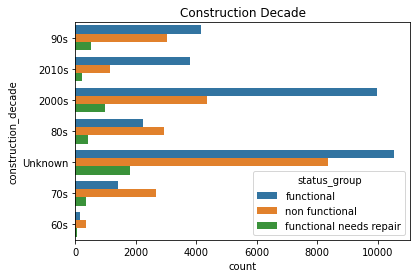

In [41]:
# Author [Jason]

sns.countplot(data=df, y='construction_decade', hue='status_group', dodge=1.0)
plt.title('Construction Decade')
plt.show()

### 1.2.3 Region

In [42]:
# Author [Jason]

# Function for Region Column Binning.
# Region Binning is done based on Data from Tanzania Water and Sanitation Network Website. 

def label_region (row):
    if row['region'] in ['Arusha','Manyara','Kilimanjaro','Tanga']:
        return "Northern Zone"
    if row['region'] in ['Kagera','Mwanza','Shinyanga','Mara']:
        return "Lake Zone"
    if row['region'] in ['Lindi','Ruvuma','Mtwara']:
        return "Southern Zone"
    if row['region'] in ['Rukwa','Mbeya','Iringa']:
        return "Southern Highlands"
    if row['region'] in ['Morogoro','Pwani','Dar es Salaam']:
        return "Coastal Zone"
    if row['region'] in ['Kigoma']:
        return "Western Zone"
    if row['region'] in ['Tabora','Singida','Dodoma']:
        return "Central Zone"
    return "Unknown"

df['zones'] = df.apply(lambda row: label_region(row), axis=1)

In [43]:
# Author [Jason]

df['zones'].value_counts()

Lake Zone             13369
Northern Zone         11859
Southern Highlands    11741
Coastal Zone           7446
Central Zone           6253
Southern Zone          5916
Western Zone           2816
Name: zones, dtype: int64

Text(0.5, 1.0, 'Zones')

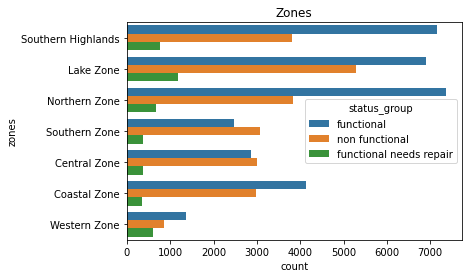

In [44]:
# Author [Jason]

sns.countplot(data=df, y='zones', hue='status_group', dodge=1.0)
plt.title('Zones')

## 1.3 Normalisation

In [45]:
# Author [Tom]

def minmax_normalisation(df, col):
    df[col + "_minmaxnormalised"] = ((df[col] - df[col].min()) / (df[col].max() / df[col].min()))
    return df

In [46]:
# Author [Tom]

def zscore_normalisation(df, col):
    df[col + "_zscorenormalise"] = ((df[col] - df[col].mean()) / df[col].std())
    return df

In [47]:
df = minmax_normalisation(df, "gps_height")
df = zscore_normalisation(df, "gps_height")

# 2 Feature Encoding / Engineering

## 2.1 Target Variable Encoding

In [48]:
# Author [Jason]

# Function for Target Variable Integer Encoding
def label_outcome (row):
    if row['status_group'] in ['functional']:
        return 0
    if row['status_group'] in ['functional needs repair']:
        return 1
    if row['status_group'] in ['non functional']:
        return 2
    return 999

df['outcome'] = df.apply(lambda row: label_outcome(row), axis=1)

In [49]:
# Author [Jason]

df['outcome'].value_counts()

0    32259
2    22824
1     4317
Name: outcome, dtype: int64

## 2.2 Categorical Feature Encoding

In [50]:
df['permit'] = df['permit'].astype(str)
df['public_meeting'] = df['public_meeting'].astype(str)

In [51]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [52]:
df = MultiColumnLabelEncoder(columns = ['basin','public_meeting','scheme_management','permit','extraction_type_class',
                                        'management','management_group','payment_type','water_quality','quantity',
                                        'source_type','source_class','waterpoint_type_group','funder_grouped','installer_grouped',
                                        'construction_decade','zones', 'cat_funder', 'cat_installer', 'extraction_type', 'payment',
                                       'waterpoint_type', 'extraction_type_group', 'quality_group','source']).fit_transform(df)

# 3 Saving

In [53]:
df.to_csv("./datasets/cleaned_water.csv")